In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv('data/custom_train.csv')

In [12]:
class_label = data['class'].unique()
class_label

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반 대화'],
      dtype=object)

In [14]:
#전처리
# 불용어 처리를 할 경우 stopwords에 단어 리스트를 제공
import re

def preprocess_sentence(sentence, stopwords=None):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = sentence.replace("\n", "")         # 구분자
    sentence = sentence.replace("\r", "")         # 구분자
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]"," ",sentence)
    sentence = sentence.strip()
    
    if stopwords:
        words = sentence.split()
        filtered_words = [word for word in words if word not in stopwords]
        sentence = ' '.join(filtered_words)
    
    return sentence

In [15]:
X = data['conversation'].apply(preprocess_sentence)
y = data['class']

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [17]:
X_list = list(np.stack(X.values))


In [18]:
X_list[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .'

## KoBert

In [19]:
# https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

# ! pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [20]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [11]:
sample = tokenizer.encode(X_list[0])

In [12]:
tokenizer.decode(sample)

'[CLS] 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.[SEP]'

In [26]:
total_data_text = list(X_list)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균, 최대, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2.5*표준편차)
max_tokens = np.mean(num_tokens) + 1 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {100 * np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함. ')

문장길이 평균 :  240.11326732673268
문장길이 최대 :  906
문장길이 표준편차 :  98.91159089852438
pad_sequences maxlen :  339
전체 문장의 89.72277227722772%가 maxlen 설정값 이내에 포함. 


In [27]:
inputs = tokenizer(X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)


In [28]:
X = tf.multiply(inputs.input_ids,inputs.attention_mask)

In [29]:
X.numpy()

array([[   2, 4299, 1457, ...,    0,    0,    0],
       [   2, 1315, 5872, ...,    0,    0,    0],
       [   2, 1457, 1763, ...,    0,    0,    0],
       ...,
       [   2, 3121, 5439, ...,    0,    0,    0],
       [   2, 4953, 4924, ...,    0,    0,    0],
       [   2, 2287, 5330, ...,    0,    0,    0]], dtype=int32)

### 데이터 분할

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, test_size=0.1, random_state=42)


In [19]:
y_train

array([2, 1, 1, ..., 3, 0, 1])

In [18]:
X_train

array([[   2, 1456, 7178, ...,    0,    0,    0],
       [   2, 3298, 6364, ...,    0,    0,    0],
       [   2, 3206, 1457, ...,    0,    0,    0],
       ...,
       [   2, 4273, 4064, ...,    0,    0,    0],
       [   2, 3945, 5595, ...,    0,    0,    0],
       [   2, 1370, 3498, ...,    0,    0,    0]], dtype=int32)

## 모델

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()   # 부모 클래스 상속 초기화, 필수는 아님 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            # tf.newaxis : 차원 추가, [:, tf.newaxis]은 열벡터로 변환 
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # 차원 추가 (1, ...)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    
    def get_config(self):
        return {
            'pos_encoding': self.pos_encoding,
        }

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    # tf.shape(key)[-1] = 워드벡터의 크기 
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    # 마스크의 1이면 큰값을 빼는 거니까 softmax를 지나면 0에 수렴 
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 워드벡터가 헤드수로 나머지 없이 나누어 져야함
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # input.shape : [batch_size, seq_len, d_model(self.num_head*self.depth)]
            # seq_len : 문장길이
            # d_model : 임베딩 차원 
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        #[batch_size, self.num_head, seq_len, self.depth)]
        # transpose를 통해 num_heads를 앞으로 불러와 병렬연산 효율성(gpu활용성)을 높임 
            # 일반적으로 뒷 차원의 크기가 클 수록 효율적
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

    def get_config(self):
        return {
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'dense': self.dense,
        }

In [6]:
# 숫자가 0인 부분을 체크한 벡터를 리턴
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# 숫자가 0인 부분도 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part: 대각요소를 가져오거나 이를 기준을 다른 것을 제거 
        # (텐서, 유지할 아래 대각요소, 유지할 위 대각요소) -1이면 전부 
        # 대각요소는 항상 유지 
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [8]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [9]:
# 전체 인코더. 인코딩 레이어를 여러개 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [10]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                num_classes,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
  
    # 인코더에서 패딩을 위한 마스크
    # output_shape:mask[:, tf.newaxis, tf.newaxis, :]를 (1,1,batch_size,sequence_length)로 변경
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), 
        name='enc_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model, 
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.GlobalAveragePooling1D()(enc_outputs)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


In [30]:
# 하이퍼파라미터
NUM_LAYERS = 12 # 인코더와 디코더의 층의 개수 
D_MODEL = 128 # 인코더와 디코더 내부의 입/출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 256 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

NUM_CLASSES = len(class_label)  #레이블 수
VOCAB_SIZE = tokenizer.vocab_size #단어사전 크기
MAX_LENGTH = X.shape[1] # maxlen

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    2614016     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           encoder[0][0]          

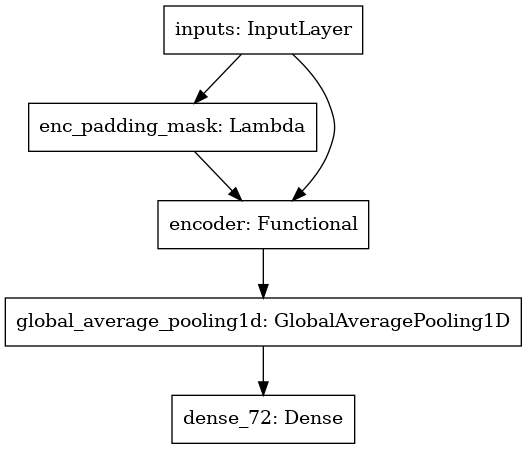

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model)

F1 score

In [34]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # 예측값을 0과 1로 반올림
    y_pred = tf.round(y_pred)

    # True Positives, False Positives, False Negatives 계산
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    # Precision, Recall 계산
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1 Score 계산
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_val

In [35]:
# 메모리 문제로 메모리 최적화 
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Mixed precision policy 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

# Optimizer 설정 (loss scale 추가)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
optimizer = mixed_precision.LossScaleOptimizer(optimizer, loss_scale='dynamic')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)


In [36]:
from tensorflow.keras.callbacks import  ModelCheckpoint

cb = ModelCheckpoint(f'models/{NUM_LAYERS}-{D_MODEL}-{NUM_HEADS}-{UNITS}.h5',
                    save_weights_only=True, 
                    save_best_only=False,    
                    monitor='val_loss',
                    mode='min',
                    verbose=1)

epochs=10
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score])

In [30]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[cb],
                    verbose=1)

Epoch 1/10
143/143 [==============================] - 50s 233ms/step - loss: 1.4369 - accuracy: 0.3520 - f1_score: 0.1990 - val_loss: 1.3596 - val_accuracy: 0.4099 - val_f1_score: 0.5610
Epoch 2/10
143/143 [==============================] - 31s 217ms/step - loss: 1.1410 - accuracy: 0.4583 - f1_score: 0.4053 - val_loss: 1.0616 - val_accuracy: 0.4970 - val_f1_score: 0.4505
Epoch 3/10
143/143 [==============================] - 31s 219ms/step - loss: 1.0333 - accuracy: 0.5305 - f1_score: 0.5119 - val_loss: 0.9302 - val_accuracy: 0.5842 - val_f1_score: 0.6527
Epoch 4/10
143/143 [==============================] - 32s 221ms/step - loss: 0.9062 - accuracy: 0.5991 - f1_score: 0.6670 - val_loss: 0.8923 - val_accuracy: 0.6198 - val_f1_score: 0.7251
Epoch 5/10
143/143 [==============================] - 31s 220ms/step - loss: 0.8211 - accuracy: 0.6431 - f1_score: 0.7328 - val_loss: 0.8729 - val_accuracy: 0.6139 - val_f1_score: 0.8128
Epoch 6/10
143/143 [==============================] - 32s 221ms/s

**결과 기록**  

> NUM_LAYERS = 4   
  D_MODEL = 256   
  NUM_HEADS = 4   
  UNITS = 512  
  DROPOUT = 0.1    
  Epoch 10/10  
  loss: 0.2240 -  accuracy: 0.9221 - f1_score: 0.8817  
  val_loss: 0.4892 - val_accuracy: 0.8475 -  val_f1_score: 0.8832  
  submit 0.8  
  
> NUM_LAYERS = 12   
  D_MODEL = 128   
  NUM_HEADS = 4  
  UNITS = 256  
  DROPOUT = 0.1 
  Epoch 20/20  
  loss: 0.2655 - accuracy: 0.9065 - f1_score: 0.8749 -  
  val_loss: 0.5450 - val_accuracy: 0.8416 - val_f1_score: 0.8813  
  submit 0.7675

In [33]:
model.save_weights('models/transformer_weights.h5')

In [31]:
model.load_weights('models/transformer_weights.h5')


In [37]:
model.save('models/transformer.h5')

TypeError: ('Not JSON Serializable:', <tf.Tensor: shape=(1, 8002, 128), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147102e-01,  5.4030228e-01,  7.6172042e-01, ...,
          1.0000000e+00,  1.1547822e-04,  1.0000000e+00],
        [ 9.0929747e-01, -4.1614681e-01,  9.8704624e-01, ...,
          9.9999994e-01,  2.3095644e-04,  1.0000000e+00],
        ...,
        [ 4.8389840e-01,  8.7512422e-01,  3.5569412e-01, ...,
          4.8303014e-01,  7.9784393e-01,  6.0286409e-01],
        [ 9.9784303e-01,  6.5645128e-02, -4.8166558e-01, ...,
          4.8291346e-01,  7.9791355e-01,  6.0277194e-01],
        [ 5.9437537e-01, -8.0418777e-01, -9.7956294e-01, ...,
          4.8279664e-01,  7.9798317e-01,  6.0267979e-01]]], dtype=float32)>)

In [34]:
# 혼동행렬
y_pred = model.predict(X_test,batch_size=1)
y_pred_classes = np.argmax(y_pred, axis=1)

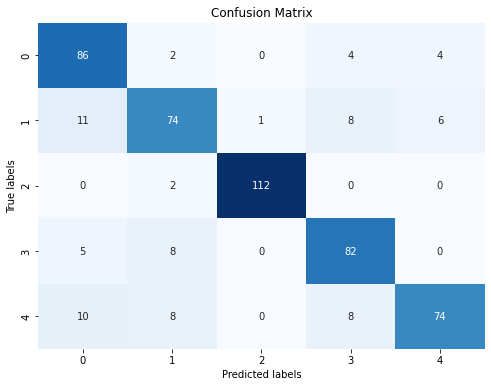

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_classes)
# 히트맵 그리기

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 불용어 제거

In [18]:
# 문맥상 진짜 의미가 없는 불용어 제거 
stopwords = ['그렇게','아','어떻게', '이렇게', '그렇군요', '있어요']
# 워드 클라우드에서 보기 편하게 일반어 제거
s = stopwords + ['내가', '다', '니','니가','넌','그냥', '너', '왜', '야','진짜',
                '나','좀', '지금', '내', '아니','우리','네','안','그','이','어',
                '그래', '그럼', '아니야', '응', '너가', '제가', '저', '거','뭐',
                '이거','여기', '저는','저도', '전', '어', '나도', '잘', '너무',
                '정말', '나는', '너도', '네가', '넌', '난', '널']

In [19]:
X_sw = data['conversation'].apply(preprocess_sentence, stopwords=s)
X_sw_list = list(np.stack(X_sw.values))


In [20]:
inputs_sw = tokenizer(X_sw_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)


In [21]:
X_sw = tf.multiply(inputs_sw.input_ids,inputs_sw.attention_mask)

In [23]:
from sklearn.model_selection import train_test_split

X_sw_train, X_sw_test, y_sw_train, y_sw_test = train_test_split(X_sw.numpy(), y, test_size=0.1, random_state=42)


In [111]:
NUM_CLASSES = len(class_label)
VOCAB_SIZE = tokenizer.vocab_size
MAX_LENGTH = X_sw.shape[1]

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더 층의 개수 
D_MODEL = 128 # 인코더 내부의 입/출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 256 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT)

model.summary()

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float16 of argument 'x'.

In [27]:
epochs=10
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score])
history = model.fit(X_sw_train,
                    y_sw_train,
                    epochs=epochs,
                    batch_size=1,
                    validation_data=(X_sw_test, y_sw_test),
                    verbose=1)



Epoch 1/10
4545/4545 [==============================] - 45s 9ms/step - loss: 1.1662 - accuracy: 0.4931 - f1_score: 0.2532 - val_loss: 0.7803 - val_accuracy: 0.6337 - val_f1_score: 0.5960
Epoch 2/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.5793 - accuracy: 0.7780 - f1_score: 0.6814 - val_loss: 0.5257 - val_accuracy: 0.8059 - val_f1_score: 0.7386
Epoch 3/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.4021 - accuracy: 0.8475 - f1_score: 0.7509 - val_loss: 0.4951 - val_accuracy: 0.8337 - val_f1_score: 0.7604
Epoch 4/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.3137 - accuracy: 0.8865 - f1_score: 0.7760 - val_loss: 0.4582 - val_accuracy: 0.8416 - val_f1_score: 0.7762
Epoch 5/10
4545/4545 [==============================] - 41s 9ms/step - loss: 0.2454 - accuracy: 0.9140 - f1_score: 0.7872 - val_loss: 0.5471 - val_accuracy: 0.8218 - val_f1_score: 0.7861
Epoch 6/10
4545/4545 [==============================] - 41s 9ms/s

#### 결과
Epoch 10/10
4545/4545 [==============================] - 42s 9ms/step - loss: 0.0847 - accuracy: 0.9734 - f1_score: 0.8024 - val_loss: 0.6752 - val_accuracy: 0.8515 - val_f1_score: 0.8059

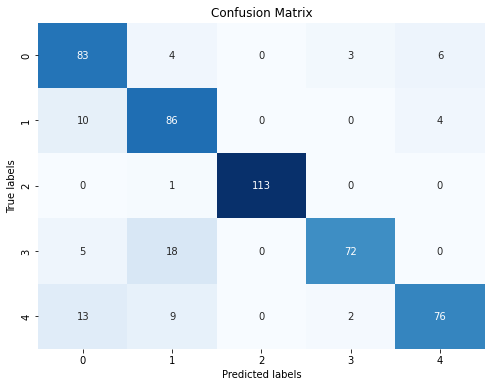

In [29]:
# 혼동행렬
y_sw_pred = model.predict(X_sw_test,batch_size=1)
y_sw_pred_classes = np.argmax(y_sw_pred, axis=1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_sw_test, y_sw_pred_classes)
# 히트맵 그리기

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [87]:
history.history['val_accuracy']

[0.6336633563041687,
 0.805940568447113,
 0.8336633443832397,
 0.8415841460227966,
 0.8217821717262268,
 0.8475247621536255,
 0.8475247621536255,
 0.8633663654327393,
 0.8455445766448975,
 0.8514851331710815]

# test submit

In [38]:
test = pd.read_csv('data/custom_test.csv')

In [39]:
test.shape

(500, 1)

In [40]:
test.head()

,conversation
0,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [41]:
test_X = test['conversation'].apply(preprocess_sentence)
test_X_list = list(np.stack(test_X.values))


In [42]:
inputs_test = tokenizer(test_X_list,return_tensors='tf', 
                   padding=True, truncation=True,max_length=maxlen)

In [43]:
test_X = tf.multiply(inputs_test.input_ids,inputs_test.attention_mask)

In [44]:
pred = model.predict(test_X, batch_size=1)

In [45]:
predicted_classes = np.argmax(pred, axis=1)


In [46]:
test['class']= predicted_classes

레이블 순서 변환

In [47]:
label_encoder.classes_

array(['갈취 대화', '기타 괴롭힘 대화', '일반 대화', '직장 내 괴롭힘 대화', '협박 대화'],
      dtype=object)

In [48]:
new_index = [1, 3, 4, 2, 0]
mapped_classes = [new_index[index] for index in predicted_classes]

서브미션 파일

In [49]:
sub = pd.read_csv("data/new_submission.csv")

In [50]:
sub['class']=mapped_classes

In [51]:
sub.to_csv('data/sub.csv')

In [52]:
sub2 = sub.copy()

In [53]:
sub2['conv'] = test['conversation']

In [54]:
sub2

,file_name,class,conv
0,t_000,1,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,2,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,2,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,3,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,3,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...,...
495,t_495,2,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
496,t_496,2,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
497,t_497,1,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
498,t_498,0,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...


score : 0.8175 